# ***Cene*** - An Image Classification, Organisation Application

*Cene* is an image classification application that aims to classify images of 6 landscapes into corresponding albums.  The landscapes this app is capable of classifying are buildings, forests, glaciers, mountains, seas and streets.  While it is unrealistic that regular users would only have images of these 6 types on their devices, this project aims to create a proof-of-concept application to demonstrate deployment of machine learning image classification models.  

## Why does Image Classification Matter?

Image recognition is a key component of artificial intelligence.  It has wide practical applications in fields such as search engines, robotics, self-driving vehicles, identity recogition security systems and much more.

Image classification has also helped to improve organisation systems.  In the digital age, consumers are able to store thousands of images on their personal devices.  The task of manually sifting through personal photos to organise them into relevant categories is an impossible task for the everday user.  However, this process can be automated by employing machine learning models such as deep neural networks and convolutional neural networks.  

## The Data

The data used for this project was sourced from [Kaggle](https://www.kaggle.com/puneet6060/intel-image-classification).  The data was intially published on [Analytics Vidhya]( https://datahack.analyticsvidhya.com) as an image classification challenge and the data was provided by Intel.  The owner of the dataset is [Puneet Bansal](https://www.kaggle.com/puneet6060).

The data consists of 24,034 building, forest, glacier, mountain, sea and street images.  The data is then split up into training and test sets which each contain 6 sub directories of the 6 image classes.  There are 14,034 images in the training set and 3,000 in the test set.  Further to this, the dataset contains 7,000 unlabelled images for predictive testing purposes.  For modeling purposes, the training set was further split in order to create a validation set.  

Here are a few example images from each class:

|Buildings	|Forest	|Glacier|Mountain|Sea|Street|
|---	|---	|---	|---	|---	|---    |
|![building](../figures/10176.jpg)|![forest](../figures/10186.jpg)|![glacier](../figures/10256.jpg)|![mountain](../figures/11023.jpg)|![sea](../figures/10420.jpg)|![street](../figures/10112.jpg)
|

As you can see, not all images are color (although the vast majority happen to be) and there are some unique augmentations to some images as you can see here with the sea image.  One tricky thing about this classification will be getting our model to distinguish between buildings and streets, given that there are usually buildings in the street images and also distinguishing between glaciers and mountains, since these also often look similar. 

The file structure of the data directory in this repo and used for modeling throughout this project is as follows:
```
.
├── data
│   ├── seg_train
│   │   ├── buildings
│   │   ├── forest
│   │   ├── glacier
│   │   ├── mountain
│   │   ├── sea
│   │   ├── street
│   ├── seg_val
│   │   ├── buildings
│   │   ├── forest
│   │   ├── glacier
│   │   ├── mountain
│   │   ├── sea
│   │   ├── street
│   ├── seg_test
│   │   ├── buildings
│   │   ├── forest
│   │   ├── glacier
│   │   ├── mountain
│   │   ├── sea
│   │   ├── street
│   ├── seg_pred
```
**Note:**  When downloading the data from Kaggle, the zip file will only contain folders for `seg_train`, `seg_test` and `seg_pred`.  The details of how to create the validation set are provided later on in this notebook.  

## Data Preparation and EDA

### Imports

In [185]:
import os, shutil
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# turn off warnings
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = FutureWarning)

# image processing
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, image

# LIME images
from skimage.io import imread
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image

# modelling
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping

parent_dir = '../'

In [186]:
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import visualisations as vis
from src import preprocessing as pp

### Plotting Parameters

In [159]:
# plot params:
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['savefig.directory'] = parent_dir + '/figures/'

### Validation Set

Our data is currently split up into labeled train and test sets and then we also have access to an unlabeled 'prediction' set.  

We want to be able to validate our model without tapping into the labeled test set too early.  For this reason, we will take 20% of the training images and create a new directory in the data folder called `seg_val`.

First, we create filepath variables for each class in the training directory:

In [160]:
train_dir = parent_dir + 'data/seg_train'

train_buildings_dir = parent_dir + 'data/seg_train/buildings'
train_forest_dir = parent_dir + 'data/seg_train/forest'
train_glacier_dir = parent_dir + 'data/seg_train/glacier'
train_mountain_dir = parent_dir + 'data/seg_train/mountain'
train_sea_dir = parent_dir + 'data/seg_train/sea'
train_street_dir = parent_dir + 'data/seg_train/street'

Next, we create variables to access the images of each class in the training data.  This will result in a list of strings of the image file names:

In [161]:
imgs_buildings = [file for file in os.listdir(train_buildings_dir) if file.endswith('.jpg')]
imgs_forest = [file for file in os.listdir(train_forest_dir) if file.endswith('.jpg')]
imgs_glacier = [file for file in os.listdir(train_glacier_dir) if file.endswith('.jpg')]
imgs_mountain = [file for file in os.listdir(train_mountain_dir) if file.endswith('.jpg')]
imgs_sea = [file for file in os.listdir(train_sea_dir) if file.endswith('.jpg')]
imgs_street = [file for file in os.listdir(train_street_dir) if file.endswith('.jpg')]

Let's now view how many images of each class are in the training data to see if we have any class imablances:

In [162]:
scenes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
img_files = [imgs_buildings, imgs_forest, imgs_glacier, imgs_mountain, imgs_sea, imgs_street]
# let's create a dictionary containing the number of images per scene
num_imgs_dict = {}
for file, scene in zip(img_files, scenes):
    print('There are', len(file), f'{scene} images')
    num_imgs_dict[scene] = len(file)

There are 2191 buildings images
There are 2271 forest images
There are 2404 glacier images
There are 2512 mountain images
There are 2274 sea images
There are 2382 street images


At first glance, it appears like the classes are fairly balanced, but let's visualize this:

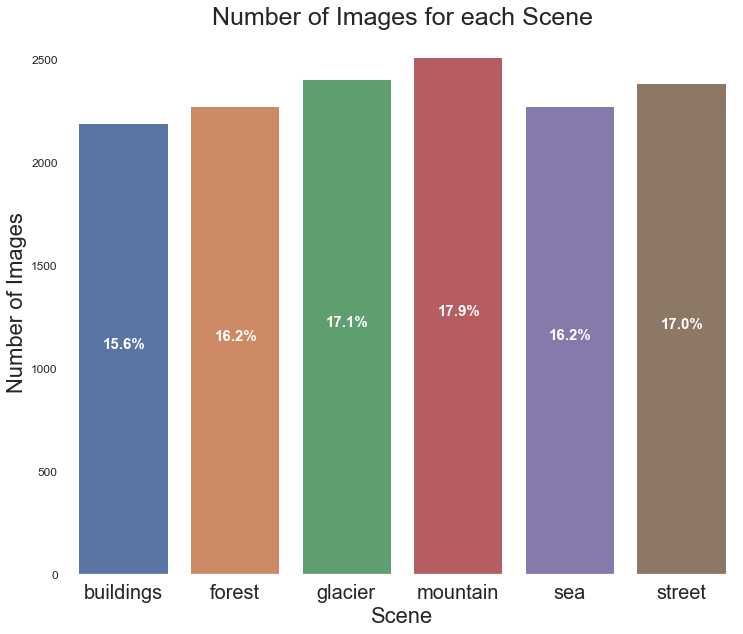

In [163]:
classes = list(num_imgs_dict.keys())
values = list(num_imgs_dict.values())

fig, ax = plt.subplots(figsize = (12, 10))
sns.set()
sns.set_style('white')
sns.color_palette("deep")
sns.barplot(classes, values)
total = np.sum(values)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x_ = p.get_x() + p.get_width() + 0.02
        y_ = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x_, y_), fontsize = 15, xytext = (x_-0.6, y_), color = 'white', fontweight = 'bold')
plt.title('Number of Images for each Scene', fontsize = 25)
plt.xlabel('Scene', fontsize = 22)
plt.ylabel('Number of Images', fontsize = 22)
plt.xticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/num_imgs_per_scene')
plt.show()

We see from this bar graph that we have relatively balanced classes with the mountain class containing the highest number of images and sea class containing the least.  

Now, let's get back to creating a new validation set.  We'll start by creating file paths for the train, test and validation sets:

In [164]:
val_folder = parent_dir + 'data/seg_val/'
test_folder = parent_dir + 'data/seg_test/'
train_folder = parent_dir + 'data/seg_train/'

Next, we create file path variables for the class folders within the `seg_val` directory:

In [165]:
val_buildings = os.path.join(val_folder, 'buildings')
val_forest = os.path.join(val_folder, 'forest')
val_glacier = os.path.join(val_folder, 'glacier')
val_mountain = os.path.join(val_folder, 'mountain')
val_sea = os.path.join(val_folder, 'sea')
val_street = os.path.join(val_folder, 'street')

Finally, let's actually create the validation directories:

In [166]:
# create the seg_val folder within the data directory
os.mkdir(val_folder)

# create the class labeled folders within the seg_val
os.mkdir(val_buildings)
os.mkdir(val_forest)
os.mkdir(val_glacier)
os.mkdir(val_mountain)
os.mkdir(val_sea)
os.mkdir(val_street)

### Train Test (Val) Split

Let's now perform the split for the validation set.  I'm going to choose an 80-20 split to make sure we don't dilute the training set too much.  Since each class has a different number of images, we create `_split_size` variables to contain 20% of the images of each class to make sure the class balances stay the same between training and validation sets:

In [167]:
# validation sets:
buildings_split_size = int(len(imgs_buildings) * 0.2)
forest_split_size = int(len(imgs_forest) * 0.2)
glacier_split_size = int(len(imgs_glacier) * 0.2)
mountain_split_size = int(len(imgs_mountain) * 0.2)
sea_split_size = int(len(imgs_sea) * 0.2)
street_split_size = int(len(imgs_street) * 0.2)

We will then randomly sample images from each class folder in the training set according to the above split sizes for each class:

In [168]:
buildings_val_set = random.sample(imgs_buildings, buildings_split_size)
forest_val_set = random.sample(imgs_forest, forest_split_size)
glacier_val_set = random.sample(imgs_glacier, glacier_split_size)
mountain_val_set = random.sample(imgs_mountain, mountain_split_size)
sea_val_set = random.sample(imgs_sea, sea_split_size)
street_val_set = random.sample(imgs_street, street_split_size)

Finally, we can move the randomly selected images from the training directory and into the validation directory:

In [169]:
# validation sets
val_sets = [buildings_val_set, forest_val_set, glacier_val_set, 
            mountain_val_set, sea_val_set, street_val_set]

# file paths of where the images currently live
train_locations = [train_buildings_dir, train_forest_dir, train_glacier_dir, 
                   train_mountain_dir, train_sea_dir, train_street_dir]

# file paths of where we want the images to go 
new_locations = [val_buildings, val_forest, val_glacier, 
               val_mountain, val_sea, val_street]

for val_set, train_location, new_location in zip(val_sets, train_locations, new_locations):
    for img in val_set:
        origin = os.path.join(train_location, img)  # where we will take the image from
        destination = os.path.join(new_location, img)  # where we want to move the image to
        shutil.move(origin, destination)

Now let's check that the images were really moved out of the train set and into the val set.  We'll do this by recounting the number of images in the training folders:

In [170]:
train_imgs_buildings = [file for file in os.listdir(train_buildings_dir) if file.endswith('.jpg')]
train_imgs_forest = [file for file in os.listdir(train_forest_dir) if file.endswith('.jpg')]
train_imgs_glacier = [file for file in os.listdir(train_glacier_dir) if file.endswith('.jpg')]
train_imgs_mountain = [file for file in os.listdir(train_mountain_dir) if file.endswith('.jpg')]
train_imgs_sea = [file for file in os.listdir(train_sea_dir) if file.endswith('.jpg')]
train_imgs_street = [file for file in os.listdir(train_street_dir) if file.endswith('.jpg')]

In [171]:
# let's create a dictionary containing the number of images per scene
new_train_imgs_dict = {}
train_img_files = [train_imgs_buildings, train_imgs_forest, train_imgs_glacier, 
             train_imgs_mountain, train_imgs_sea, train_imgs_street]
for file, scene in zip(train_img_files, scenes):
    print('There are', len(file), f'{scene} images')
    new_train_imgs_dict[scene] = len(file)

There are 1753 buildings images
There are 1817 forest images
There are 1924 glacier images
There are 2010 mountain images
There are 1820 sea images
There are 1906 street images


Compare this with original amount in training set:

In [172]:
num_imgs_dict

{'buildings': 2191,
 'forest': 2271,
 'glacier': 2404,
 'mountain': 2512,
 'sea': 2274,
 'street': 2382}

Now let's check the move was correct for the validation set:

In [173]:
val_imgs_buildings = [file for file in os.listdir(val_buildings) if file.endswith('.jpg')]
val_imgs_forest = [file for file in os.listdir(val_forest) if file.endswith('.jpg')]
val_imgs_glacier = [file for file in os.listdir(val_glacier) if file.endswith('.jpg')]
val_imgs_mountain = [file for file in os.listdir(val_mountain) if file.endswith('.jpg')]
val_imgs_sea = [file for file in os.listdir(val_sea) if file.endswith('.jpg')]
val_imgs_street = [file for file in os.listdir(val_street) if file.endswith('.jpg')]

val_img_files = [val_imgs_buildings, val_imgs_forest, val_imgs_glacier, 
             val_imgs_mountain, val_imgs_sea, val_imgs_street]

# let's create a dictionary containing the number of images per scene
len_val_imgs_dict = {}
for file, scene in zip(val_img_files, scenes):
    print('There are', len(file), f'{scene} images')
    len_val_imgs_dict[scene] = len(file)

There are 438 buildings images
There are 454 forest images
There are 480 glacier images
There are 502 mountain images
There are 454 sea images
There are 476 street images


So, we now have a validation set with 20% of the training images.  We'll be able to use this for our modelling and keep our test set clean. 

Finally, let's see how many images we have in training, test, and validation:

In [174]:
# training
sum(list(new_train_imgs_dict.values()))

11230

In [175]:
# validation
sum(list(len_val_imgs_dict.values()))

2804

And we know there are 3000 in the test set (as mentioned in the introduction).

### Prepare for Modelling

In order to input these images into our models we will need to scale the images as well as create Keras Image Data Generator objects for each set.  We choose a batch size of 32 for each set.

In [176]:
# train generator:
train_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(train_folder, target_size = (299, 299), batch_size = 32)

# val generator:
val_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(val_folder, target_size = (299, 299), batch_size = 32)

# test generator:
test_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(test_folder, target_size = (299, 299), batch_size = 32)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Now, we create variables so we have access to both the images and their labels.

In [177]:
# create the data sets
train_images, train_labels = next(train_gen)
val_images, val_labels = next(val_gen)
test_images, test_labels = next(test_gen)

Let's explore the number of samples, pixels and shape details of these datasets:

In [178]:
print ("Number of training samples: " + str(train_images.shape[0]))
print ("Number of pixels in training samples: " + str(train_images.shape[1]))
print ("Number of testing samples: " + str(test_images.shape[0]))
print ("Number of pixels in testing samples: " + str(test_images.shape[1]))
print ("Number of validation samples: " + str(val_images.shape[0]))
print ("Train images shape: " + str(train_images.shape))
print ("Train labels shape: " + str(train_labels.shape))
print ("Test images shape: " + str(test_images.shape))
print ("Test labels shape: " + str(test_labels.shape))
print ("Val images shape: " + str(val_images.shape))
print ("Val labels shape: " + str(val_labels.shape))

Number of training samples: 32
Number of pixels in training samples: 299
Number of testing samples: 32
Number of pixels in testing samples: 299
Number of validation samples: 32
Train images shape: (32, 299, 299, 3)
Train labels shape: (32, 6)
Test images shape: (32, 299, 299, 3)
Test labels shape: (32, 6)
Val images shape: (32, 299, 299, 3)
Val labels shape: (32, 6)


## Modeling

Here we will create a first simple neural network model using a basic keras Sequential model with Dense layers.  We will then iterate upon this model using convolutional neural networks (CNNs) and also apply transfer learning models.  

### Metrics

Our aim for this model is that it classifies images as accurately as possible.  There is no benefit towards seeing less false negatives over false positives and visa versa since both scenarios result in a misclassification.  For this reason, we choose to optimize for accuracy.  

### First Simple Model (FSM):  Basic Neural Network

We'll first create a simple neural network with one hidden Dense layer to get a baseline performance model.  We'll use the `categorical_crossentropy` loss function and `adam` optimizer.  

In [19]:
# create sequential model object:
fsm = Sequential()

# flatten shape to 100x100
fsm.add(Flatten(input_shape = (299, 299, 3)))

# create input layer:
fsm.add(Dense(units = 64, activation = 'relu', input_shape = (299, 3)))

# create 1 hidden layer:
fsm.add(Dense(units = 128, activation = 'relu'))

# create output layer:
fsm.add(Dense(units = 6, activation = 'softmax'))

# compile the model:
fsm.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Let's inspect a summary of our model architecture:

In [20]:
fsm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 268203)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                17165056  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 17,174,150
Trainable params: 17,174,150
Non-trainable params: 0
_________________________________________________________________


#### Fit the model

For our fsm, we'll start with just 15 epochs but include a patience of 5 in our early stopping instance incase our first model plateaus quickly.  

In [21]:
callback = EarlyStopping(patience = 5)
fsm_results = fsm.fit_generator(train_gen, epochs = 15, validation_data = val_gen, callbacks = [callback])

Epoch 1/15
352/352 [==============================] - 105s 298ms/step - loss: 3.9993 - accuracy: 0.3327 - val_loss: 1.6179 - val_accuracy: 0.3684
Epoch 2/15
352/352 [==============================] - 102s 290ms/step - loss: 1.5457 - accuracy: 0.3917 - val_loss: 1.6372 - val_accuracy: 0.4551
Epoch 3/15
352/352 [==============================] - 103s 292ms/step - loss: 1.5173 - accuracy: 0.3852 - val_loss: 1.7450 - val_accuracy: 0.2518
Epoch 4/15
352/352 [==============================] - 103s 293ms/step - loss: 1.5666 - accuracy: 0.3205 - val_loss: 1.5656 - val_accuracy: 0.3138
Epoch 5/15
352/352 [==============================] - 104s 296ms/step - loss: 1.5459 - accuracy: 0.3224 - val_loss: 1.4749 - val_accuracy: 0.3074
Epoch 6/15
352/352 [==============================] - 101s 286ms/step - loss: 1.5285 - accuracy: 0.3310 - val_loss: 1.5693 - val_accuracy: 0.3178
Epoch 7/15
352/352 [==============================] - 102s 288ms/step - loss: 1.4971 - accuracy: 0.3404 - val_loss: 1.4376 -

Let's plot the loss and accuracy for the training and validation sets and then we'll evaluate this fsm.

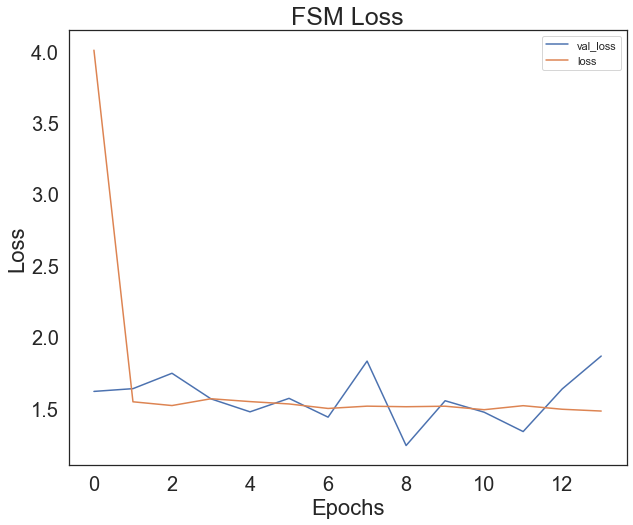

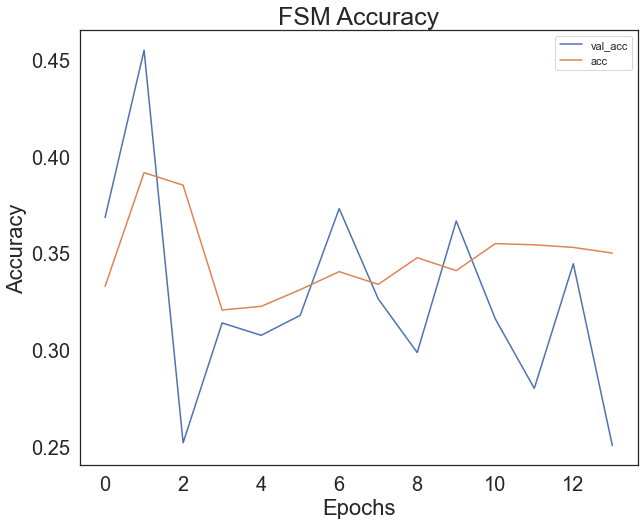

In [22]:
vis.loss_acc_vis(fsm_results, 'FSM', save_as = 'fsm')

Let's save this model now so we have access to it later. 

In [25]:
save_model(fsm, filepath = parent_dir + 'models/report_fsm', overwrite = True, include_optimizer = True)

#### Evaluate the Model

We see here that, overall, the model does not have very good accuracy, with a training score of 0.35 and validation score of 0.2504.  Convergence has not been reached for the validation loss (nor the train set for that matter) as you can see it is still quite erratic in its behaviour.  The training loss seems to have plateaued somehwat but it seems like the accuracy might still be trending upwards.  Overall, the training accuracy is higher than the validation accuracy which demonstrates that this model is overfitting.  We can certainly do better.

Before we move onto our next iteration, let's first have a look at how this baseline model is performing by looking at some LIME visualizations to see what the model is picking up on.

#### LIME Visualization

Here, I load in the model we just ran in case you need to restart this notebook or rerun for any reason and don't want to wait for the fsm to run again. (You'll also get different results if you rerun the notebook again).

In [69]:
fsm = load_model(parent_dir + 'models/report_fsm', custom_objects = None, compile = True)

Here, I'm going to randomly pick 1 image from each class and view how the model is performing on it.  I'll create a list of file paths to these images:

In [71]:
path_list = ['../data/seg_train/buildings/12536.jpg', '../data/seg_train/glacier/10024.jpg', '../data/seg_train/sea/10053.jpg',
           '../data/seg_train/forest/10050.jpg', '../data/seg_train/mountain/10027.jpg', '../data/seg_train/street/10019.jpg']

The data needs to be colour images and a certain shape in order to run in lime so we perform that preprocessing here:
(The code of the below preprocessing steps was found [here](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb))

In [72]:
output = []
for img_path in path_list:
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = np.divide(x, 255.0)
    output.append(x)
images = np.vstack(output)

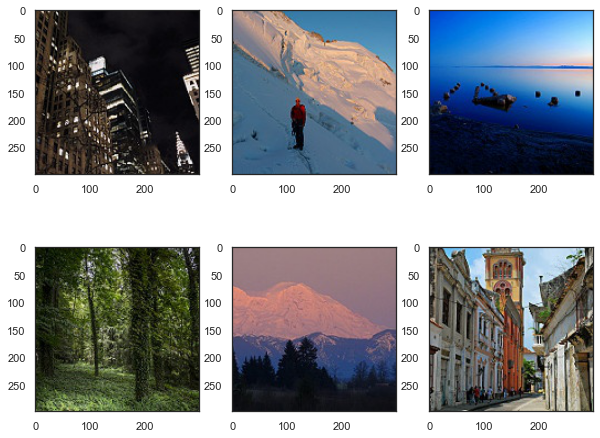

In [87]:
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(images[i-1])

Let's see what parts of the images the model is picking up on:

#### Building Image

In [208]:
# instantiate lime explainer object
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images[0], fsm.predict, top_labels = 5, 
                                         hide_color = None, num_samples = 1000)

**We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden**

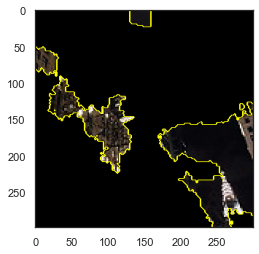

In [209]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig(parent_dir + 'figures/fsm_buildings_borders')

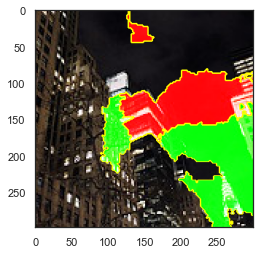

In [210]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));
plt.savefig(parent_dir + 'figures/fsm_buildings_pro_con')

For a first model, it is not doing as bad as expected.  It does appear to be picking up on mostly building portions of the image. 

#### Glacier Image

In [136]:
# instantiate lime explainer object
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images[1], fsm.predict, top_labels = 5, 
                                         hide_color = None, num_samples = 1000)

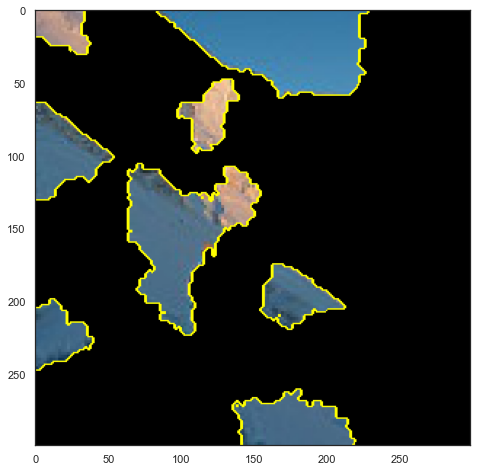

In [137]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig(parent_dir + 'figures/glacier_borders')

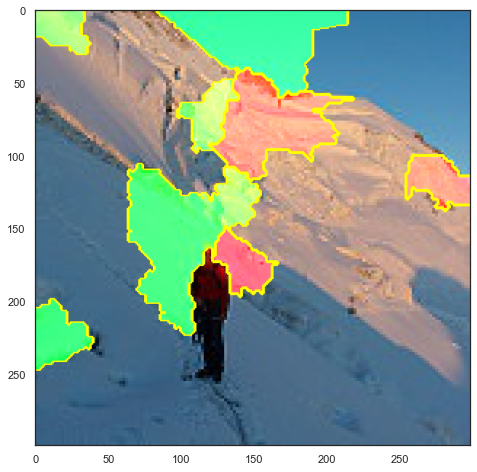

In [138]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));
plt.savefig(parent_dir + 'figures/glacier_pro_con')

The glacier images are more difficult to classify given that there are less distinctive patterns between snow and sky and similar colour schemes.  The model does however appear to be able to separate the human out of this image.  Again, not too bad given the poor performing model accuracy. 

#### Sea Image

In [139]:
# instantiate lime explainer object
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images[2], fsm.predict, top_labels = 5, 
                                         hide_color = None, num_samples = 1000)

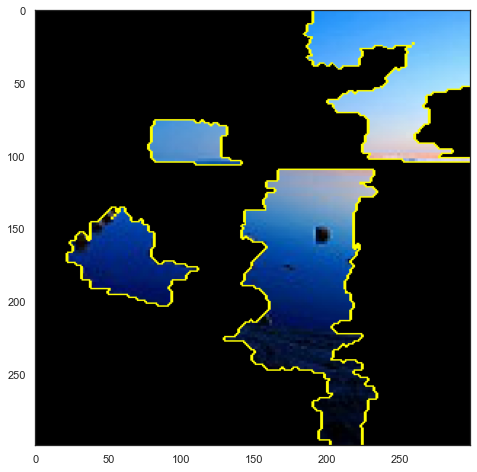

In [140]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig(parent_dir + 'figures/sea_borders')

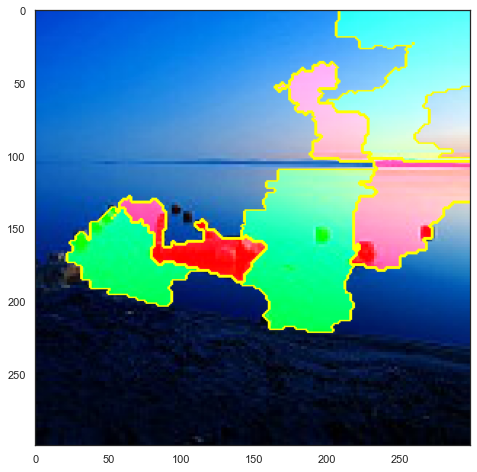

In [141]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));
plt.savefig(parent_dir + 'figures/sea_pro_con')

This sea image would again be a difficult one to classify given the similarity between the sky and the ocean here.  However, it has been able to discern the horizon point it seems and I would argue it is picking up on more sea than it is sky. 

#### Forest Image

In [142]:
# instantiate lime explainer object
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images[3], fsm.predict, top_labels = 5, 
                                         hide_color = None, num_samples = 1000)

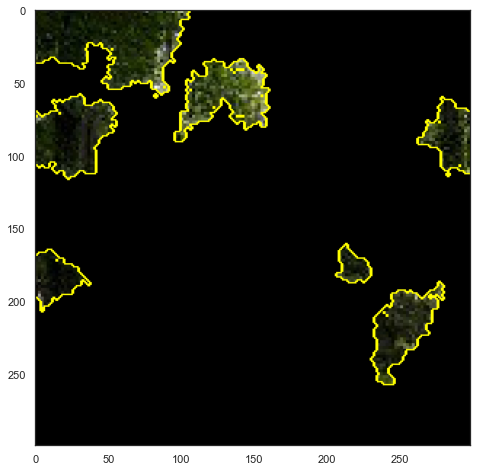

In [143]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig(parent_dir + 'figures/forest_borders')

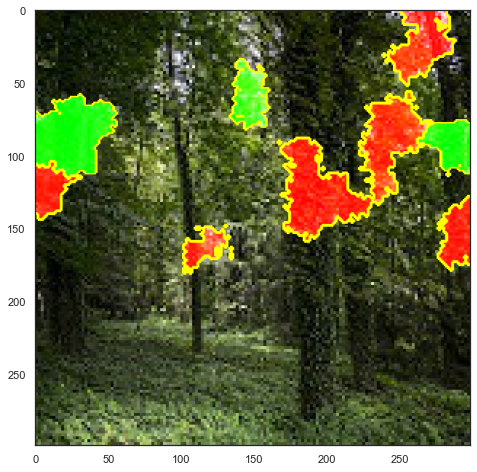

In [144]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));
plt.savefig(parent_dir + 'figures/forest_pro_con')

Another difficult image, but we do see it is picking up on foliage amongst the forest. 

#### Mountain Image

In [145]:
# instantiate lime explainer object
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images[4], fsm.predict, top_labels = 5, 
                                         hide_color = None, num_samples = 1000)

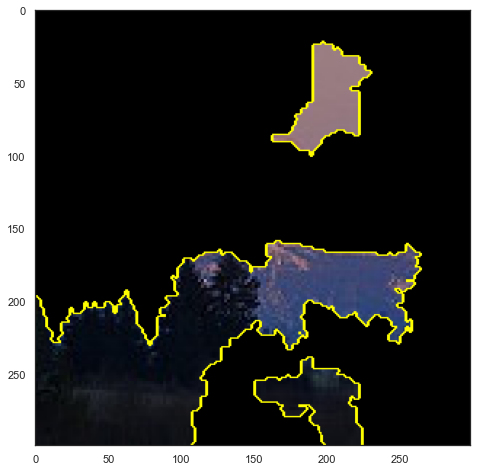

In [146]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig(parent_dir + 'figures/mountain_borders')

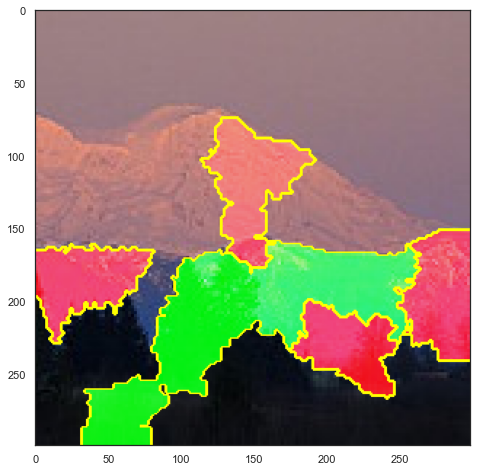

In [147]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));
plt.savefig(parent_dir + 'figures/mountain_pro_con')

Once again, it is identifying mostly mountains. 

#### Street Image

In [148]:
# instantiate lime explainer object
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images[5], fsm.predict, top_labels = 5, 
                                         hide_color = None, num_samples = 1000)

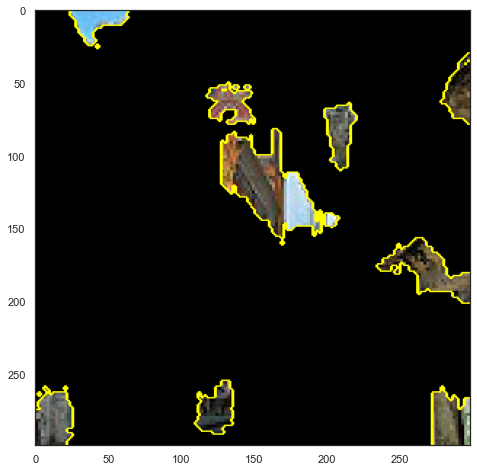

In [149]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig(parent_dir + 'figures/street_borders')

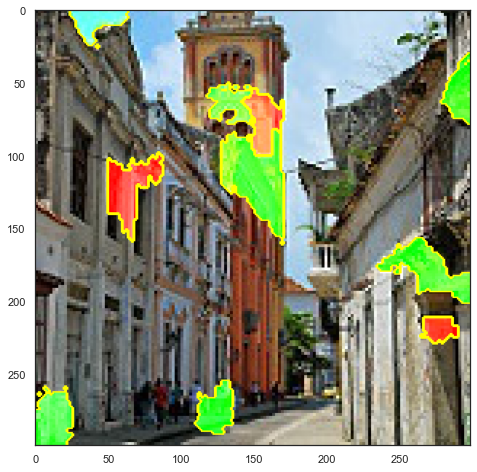

In [150]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));
plt.savefig(parent_dir + 'figures/street_pro_con')

One tricky thing with this image classification task is going to be the model being able to distinguish between street images and building images (and also mountain and glaciers).  As you can see here the model has predominantly picked up on the buildings in this street image.  

Let's continue with our model iterations.

### Model 2:  Adding Layers and Regularization

Since our fsm appeared to be overfitting the data, we are going to try adding some dropout regularization layers to our model as well as add some extra hidden layers.  We'll also increase the number of epochs the model has in order to see if we can see some convergence in the loss and accuracy. 

In [179]:
# create sequential model object:
model2 = Sequential()

# flatten shape to 100x100
model2.add(Flatten(input_shape = (299, 299, 3)))

# create input layer:
model2.add(Dense(units = 64, activation = 'relu', input_shape = (299, 3)))

# create 2 hidden layers with dropout reg.:
model2.add(Dense(units = 128, activation = 'relu'))
model2.add(Dropout(0.3))

model2.add(Dense(units = 32, activation = 'relu'))
model2.add(Dropout(0.3))

# create output layer:
model2.add(Dense(units = 6, activation = 'softmax'))

# compile the model:
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Let's inspect a summary of our model architecture:

In [180]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 268203)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                17165056  
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                

#### Fit the model

As we mentioned, we'll increase the number of epochs for this model and increase the early stopping to a patience of 10 to give the model more time to converge. 

In [181]:
callback = EarlyStopping(patience = 10)
model2_results = model2.fit_generator(train_gen, epochs = 40, validation_data = val_gen, callbacks = [callback])

Epoch 1/40
351/351 [==============================] - 107s 305ms/step - loss: 2.8931 - accuracy: 0.1711 - val_loss: 1.7911 - val_accuracy: 0.1790
Epoch 2/40
351/351 [==============================] - 103s 294ms/step - loss: 1.7911 - accuracy: 0.1784 - val_loss: 1.7974 - val_accuracy: 0.1790
Epoch 3/40
351/351 [==============================] - 104s 296ms/step - loss: 1.7911 - accuracy: 0.1790 - val_loss: 1.8004 - val_accuracy: 0.1790
Epoch 4/40
351/351 [==============================] - 102s 290ms/step - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7931 - val_accuracy: 0.1790
Epoch 5/40
351/351 [==============================] - 102s 291ms/step - loss: 1.7909 - accuracy: 0.1790 - val_loss: 1.7937 - val_accuracy: 0.1790
Epoch 6/40
351/351 [==============================] - 100s 286ms/step - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7785 - val_accuracy: 0.1790
Epoch 7/40
351/351 [==============================] - 102s 290ms/step - loss: 1.7909 - accuracy: 0.1790 - val_loss: 1.8060 -

Let's plot the loss and accuracy for the training and validation sets and then we'll evaluate this model.

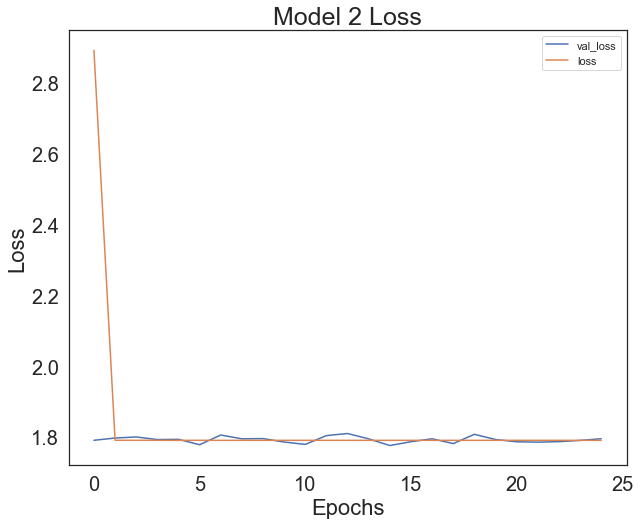

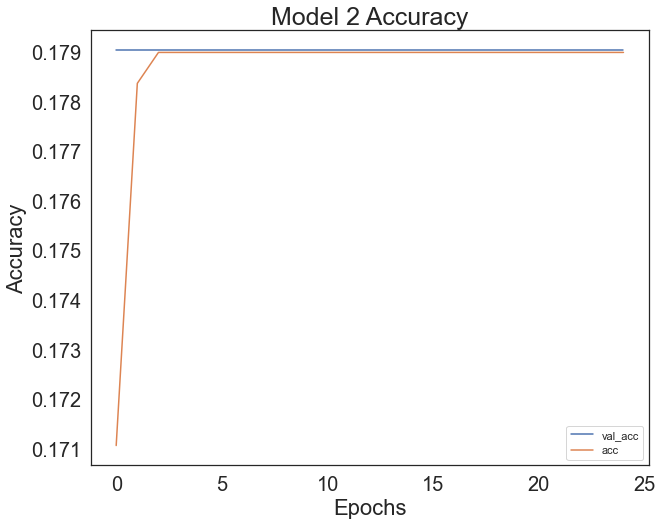

In [182]:
vis.loss_acc_vis(model2_results, 'Model 2', save_as = 'report_model2')

Let's save this model now so we have access to it later. 

In [183]:
save_model(model2, filepath = parent_dir + 'models/report_model2', overwrite = True, include_optimizer = True)

#### LIME Visualization

In [214]:
# instantiate lime explainer object
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images[0], model2.predict, top_labels = 5, 
                                         hide_color = None, num_samples = 1000)

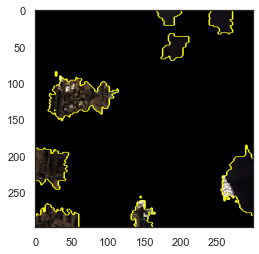

In [215]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig(parent_dir + 'figures/m2_buildings_borders')

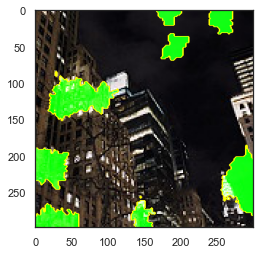

In [216]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));
plt.savefig(parent_dir + 'figures/m2_buildings_pro_con')

#### Evaluate the Model

INSERT MODEL 2 EVALUATION 

### Model 3:  CNN Model

So far we have just been creating deep neural networks.  Now, I'm going to employ convolutional neural networks which are notorious for image classification.  

In [187]:
model3 = Sequential()

# input layer
model3.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = (299, 299, 3), data_format = "channels_last"))
model3.add(MaxPooling2D((2, 2)))

# hidden layer1
model3.add(Conv2D(128, (4, 4), activation = 'relu'))
model3.add(MaxPooling2D((2, 2)))

# hidden layer 2
model3.add(Conv2D(64, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D((2, 2)))

# flatten layer
model3.add(Flatten())

# final dense layer
model3.add(Dense(32, activation = 'relu'))

# output layer
model3.add(Dense(6, activation = 'softmax'))

In [188]:
# compile
model3.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

#### Fit the model

This model will take much longer than the previous two to run.  For this reason I'm only going to run for 30 epochs and I will keep the early stopping patience at 10.  

In [189]:
results3 = model3.fit_generator(train_gen, epochs = 30, validation_data = val_gen, callbacks = [callback])

Epoch 1/30
351/351 [==============================] - 2940s 8s/step - loss: 1.0669 - accuracy: 0.5760 - val_loss: 0.5617 - val_accuracy: 0.6847
Epoch 2/30
351/351 [==============================] - 2932s 8s/step - loss: 0.7552 - accuracy: 0.7152 - val_loss: 0.8079 - val_accuracy: 0.7397
Epoch 3/30
351/351 [==============================] - 2931s 8s/step - loss: 0.6043 - accuracy: 0.7806 - val_loss: 0.4227 - val_accuracy: 0.7411
Epoch 4/30
351/351 [==============================] - 2934s 8s/step - loss: 0.4728 - accuracy: 0.8278 - val_loss: 0.7246 - val_accuracy: 0.7857
Epoch 5/30
351/351 [==============================] - 2930s 8s/step - loss: 0.3399 - accuracy: 0.8784 - val_loss: 0.5311 - val_accuracy: 0.7896
Epoch 6/30
351/351 [==============================] - 2930s 8s/step - loss: 0.2374 - accuracy: 0.9219 - val_loss: 0.2999 - val_accuracy: 0.7821
Epoch 7/30
351/351 [==============================] - 2931s 8s/step - loss: 0.1518 - accuracy: 0.9514 - val_loss: 0.8167 - val_accuracy:

Let's inspect a summary of our model architecture:

Let's plot the loss and accuracy for the training and validation sets and then we'll evaluate this model.

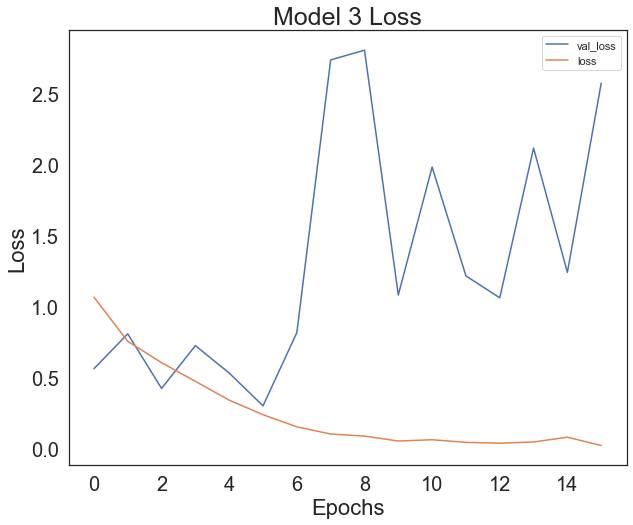

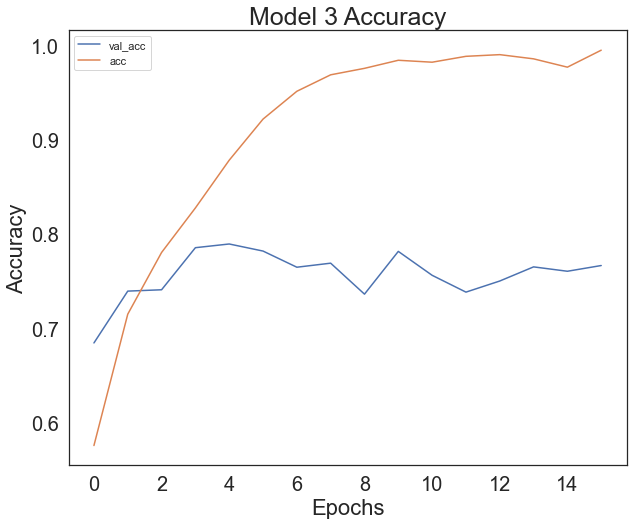

In [191]:
vis.loss_acc_vis(results3, 'Model 3', save_as = 'report_model3')

Let's save this model now so we have access to it later. 

In [192]:
save_model(model3, filepath = parent_dir + 'models/report_model3', overwrite = True, include_optimizer = True)

#### LIME Visualization

In [217]:
# instantiate lime explainer object
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images[0], model3.predict, top_labels = 5, 
                                         hide_color = None, num_samples = 1000)

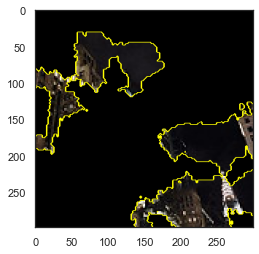

In [218]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.savefig(parent_dir + 'figures/m3_buildings_borders')

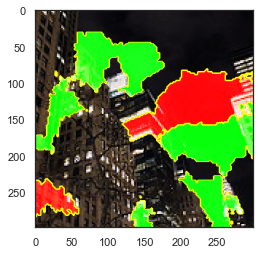

In [219]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));
plt.savefig(parent_dir + 'figures/m3_buildings_pro_con')

#### Evaluate the Model

INSERT MODEL 3 EVALUATION 

### Model 4:  CNN Model with Data Augmentation

For this model, I am going to add data augmentation which performs manipulations to the images such a flipping, rotating and shifting the images.  This gives the model a chance to train on 'different versions' of the images which inhances its learning abilities.  I am also going to add some Batch Normalization layers as well as a Dropout layer to help with the overfitting we have seen previously.  

In [193]:
# create image generator that augments the data in the following ways:
train_aug_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                                       shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

# create training generator
train_aug_generator = train_aug_datagen.flow_from_directory(train_folder, target_size = (299, 299), batch_size = 32)

# Note we do not augment the validation/test data

Found 11233 images belonging to 6 classes.


In [194]:
model4 = Sequential()

# input
model4.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = (299, 299, 3), data_format = "channels_last"))
model4.add(MaxPooling2D((2, 2)))

# hidden layers 
model4.add(Conv2D(128, (3, 3), activation = 'relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(256, (3, 3), activation = 'relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(256, (3, 3), activation = 'relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(128, (3, 3), activation = 'relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))

# flatten layer
model4.add(Flatten())

# dense hidden layer and dropout regularization layer
model4.add(Dense(512, activation = 'relu'))
model4.add(Dropout(0.5))

# output layer
model4.add(Dense(6, activation = 'softmax'))

In [195]:
# compile
model4.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

### Fit the model

This model took roughly 7-8 hours to run on a 2015 MacBook Pro. 

In [ ]:
results4 = model4.fit_generator(train_aug_generator, steps_per_epoch = 80, epochs = 50, 
                                    validation_data = val_gen, validation_steps = 50, callbacks = [callback])

Let's plot the loss and accuracy for the training and validation sets and then we'll evaluate this model.

In [ ]:
vis.loss_acc_vis(model4_results, 'Model 4', save_as = 'report_model4')

Let's save this model now so we have access to it later. 

In [ ]:
save_model(model4, filepath = parent_dir + 'models/report_model4', overwrite = True, include_optimizer = True)

### Evaluate the Model

INSERT MODEL 4 EVALUATION 